In [ ]:
from tensorflow.keras.datasets import reuters
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import time

from sklearn.naive_bayes import ComplementNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [5]:
def decode_to_text(text, index_to_word) :
    # 정수형태의 벡터를 텍스트로 디코딩 합니다.
    decoded_text = []
    for i in range(len( text)):
        t = ' '.join([index_to_word[index] for index in text[i]])
        decoded_text.append(t)
    
    return decoded_text


def load_reuters_by_vocab_sizes(vocab_sizes): 
    
    # 1.데이터를 불러오고
    # 2.단어사전에 특수토큰을 추가하고
    # 3.텍스트를 토큰화 한 뒤 벡터화를 진행합니다.
    
    data_by_vocab = {}

    for size in vocab_sizes:
        (x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=size, test_split=0.2)
        
        word_index = reuters.get_word_index(path="reuters_word_index.json")
        index_to_word = { index+3 : word for word, index in word_index.items() }
        # index_to_word에 숫자 0은 <pad>, 숫자 1은 <sos>, 숫자 2는 <unk>를 넣어줍니다.
        for index, token in enumerate(("<pad>", "<sos>", "<unk>")):
            index_to_word[index]=token
    
        #DTM
        dtmvector = CountVectorizer()
        #TF-IDF
        tfidf_transformer = TfidfTransformer()
        
        decoded_train = decode_to_text(x_train, index_to_word)
        decoded_test = decode_to_text(x_test, index_to_word)
        
        # DTM으로 변환
        dtm_train= dtmvector.fit_transform(decoded_train)
        dtm_test = dtmvector.transform(decoded_test) 
        
        #DTM을 TF-IDF 행렬로 변환
        tfidfv_train = tfidf_transformer.fit_transform(dtm_train)
        tfidfv_test = tfidf_transformer.transform(dtm_test) 
        
        data_by_vocab[size] = {
            'x_train': x_train,  #
            'y_train': y_train,
            'x_test': x_test, #
            'y_test': y_test,
            'decoded_train' : decoded_train, #
            'decoded_test' : decoded_test,  #
            'tfidfv_train' : tfidfv_train, 
            'tfidfv_test' : tfidfv_test
        }

    return data_by_vocab

- 전체 고유 토큰 수 (vocab size): 30980
- 빈도가 1회 이하인 토큰 수: 10308
- 전체 토큰 1638886, 상위 5000개 토큰 1530903
- 상위 5000개 토큰이 전체에서 차지하는 비중: 93.41%

-> num_words를 5000으로 하면 단어 사전이 전체 빈도수에서 차지하는 비중이 93%입니다.

- Top 100 tokens coverage: 48.23%
- Top 500 tokens coverage: 69.18%
- Top 1000 tokens coverage: 78.31%
- Top 2000 tokens coverage: 85.96%
- Top 5000 tokens coverage: 93.41%
- Top 10000 tokens coverage: 97.26%
- Top 20000 tokens coverage: 99.29%
- Top 30000 tokens coverage: 99.94%

-> num_words를 100, 1000, 10000으로 설정하여 빈도수 기준 약 48%, 78%, 97%로 실험을 진행합니다.

In [6]:
vocab_sizes = [100, 1000, 10000]
data_by_vocab = load_reuters_by_vocab_sizes(vocab_sizes)

In [8]:
for size in vocab_sizes:
    print(f'\n--------------- [vocab_size {size}] ---------------\n')
    x_train = data_by_vocab[size]['tfidfv_train']
    x_test = data_by_vocab[size]['tfidfv_test']
    y_train = data_by_vocab[size]['y_train']
    y_test = data_by_vocab[size]['y_test']
    num_classes = max(y_train) + 1
    print(f'훈련 샘플의 수: {x_train.shape}')
    print(f'테스트 샘플의 수: {x_test.shape}')
    print(f'훈련 레이블의 수: {y_train.shape}')
    print(f'테스트 레이블의 수: {y_test.shape}')
    print('전체 클래스의 수 : {}'.format(num_classes))
    
    # CNB 모델 실험
    cb_start = time.time()
    cb = ComplementNB()
    cb.fit(x_train, y_train)
    cb_pred = cb.predict(x_test)
    cb_end = time.time()
    cb_time = cb_end - cb_start
    cb_report = classification_report(y_test, cb_pred, zero_division=0, output_dict=True)
    
    print('\ncb f1 = ', cb_report['weighted avg']['f1-score'])
    print('cb accuracy = ', cb_report['accuracy'])
    print('cb train_time =', round(cb_time,2))
    
    # DecisionTree 모델 실험
    tree_start = time.time()
    tree = DecisionTreeClassifier()
    tree.fit(x_train, y_train)
    tree_pred = tree.predict(x_test)
    tree_end = time.time()
    tree_time = tree_end - tree_start
    tree_report = classification_report(y_test, tree_pred, zero_division=0, output_dict=True)
    
    print('\ntree f1 = ', tree_report['weighted avg']['f1-score'])
    print('tree accuracy = ', tree_report['accuracy'])
    print('tree train_time =', round(tree_time,2))


--------------- [vocab_size 100] ---------------

훈련 샘플의 수: (8982, 85)
테스트 샘플의 수: (2246, 85)
훈련 레이블의 수: (8982,)
테스트 레이블의 수: (2246,)
전체 클래스의 수 : 46

cb f1 =  0.5173688127962517
cb accuracy =  0.5734639358860196
cb train_time = 0.01

tree f1 =  0.5968157864572708
tree accuracy =  0.5997328584149599
tree train_time = 1.42

--------------- [vocab_size 1000] ---------------

훈련 샘플의 수: (8982, 969)
테스트 샘플의 수: (2246, 969)
훈련 레이블의 수: (8982,)
테스트 레이블의 수: (2246,)
전체 클래스의 수 : 46

cb f1 =  0.6972989886481723
cb accuracy =  0.7346393588601959
cb train_time = 0.02

tree f1 =  0.6872223542297597
tree accuracy =  0.6914514692787177
tree train_time = 4.11

--------------- [vocab_size 10000] ---------------

훈련 샘플의 수: (8982, 9670)
테스트 샘플의 수: (2246, 9670)
훈련 레이블의 수: (8982,)
테스트 레이블의 수: (2246,)
전체 클래스의 수 : 46

cb f1 =  0.7456682614453047
cb accuracy =  0.7707034728406055
cb train_time = 0.04

tree f1 =  0.6917239346669356
tree accuracy =  0.6954585930543188
tree train_time = 6.1


팀 M2에서는 vocab_size를 100, 1000, 10000으로 설정하여 8개의 머신러닝 모델을 실험했습니다.
- 나이브 베이즈 분류기, CNB, 로지스틱 회귀, 서포트 벡터 머신, 결정 트리, 랜덤 포레스트, 그래디언트 부스팅 트리, 보팅

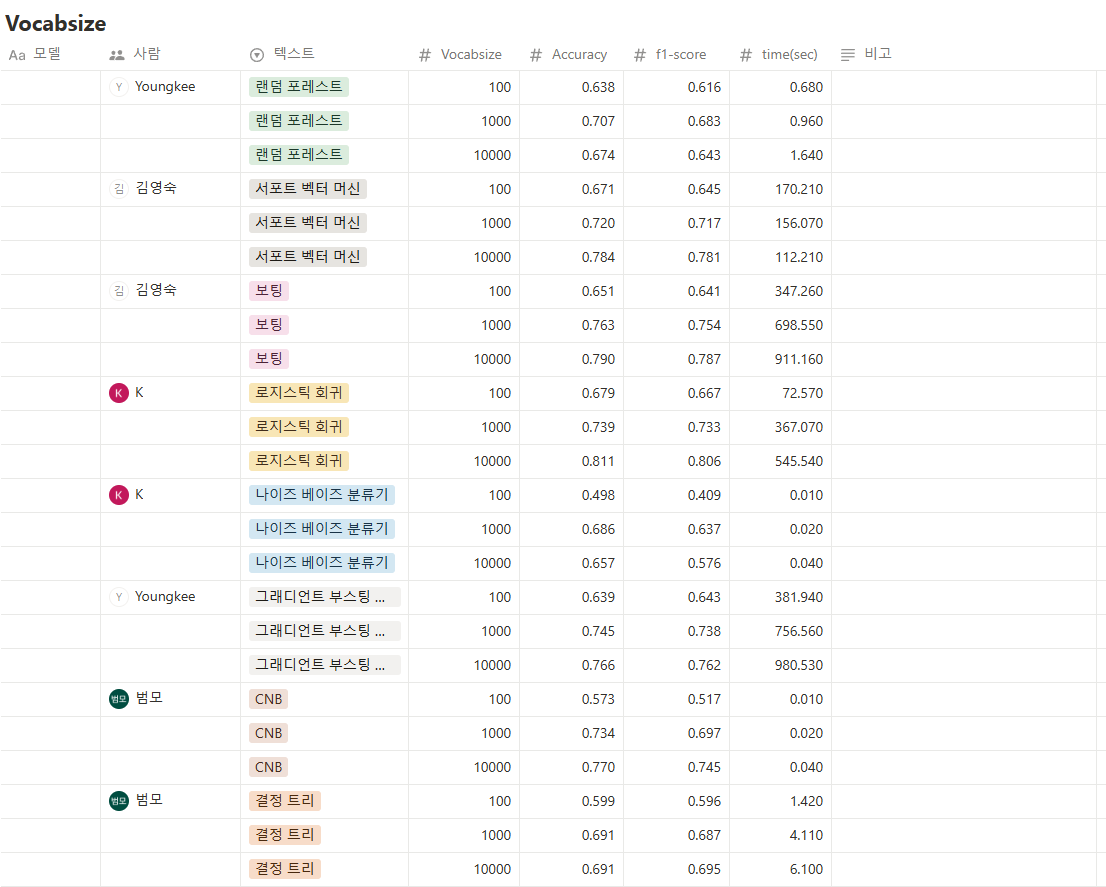

- 딥러닝 모델인 GRU로 실험진행

In [52]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K

In [55]:
for size in vocab_sizes:
    print(f'\n--------------- [vocab_size {size}] ---------------\n')
    K.clear_session()
    x_train = data_by_vocab[size]['x_train']
    x_test = data_by_vocab[size]['x_test']
    y_train = data_by_vocab[size]['y_train']
    y_test = data_by_vocab[size]['y_test']
    num_classes = max(y_train) + 1
#     max_len = max(len(seq) for seq in x_train)
    max_len = 200
    
    print(f'훈련 샘플의 수: {x_train.shape}')
    print(f'테스트 샘플의 수: {x_test.shape}')
    print(f'훈련 레이블의 수: {y_train.shape}')
    print(f'테스트 레이블의 수: {y_test.shape}')
    print('전체 클래스의 수 : {}'.format(num_classes))
    print('문장 최대 길이 : {}'.format(max_len))
    
    # 패딩
    x_train = pad_sequences(x_train, maxlen=max_len, padding='pre') # RNN 계열이라 앞쪽에 패딩
    x_test = pad_sequences(x_test, maxlen=max_len, padding='pre')
    
    gru_model = Sequential()
    gru_model.add(Embedding(input_dim=size, output_dim=128, input_length=max_len))
    gru_model.add(GRU(128))
    gru_model.add(Dense(num_classes, activation='softmax'))  # 분류기
    
    gru_model.compile(
    optimizer='adam',
    loss=SparseCategoricalCrossentropy(),
    metrics=['accuracy'])
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    
    gru_start = time.time()
    gru_model.fit(x_train, y_train, epochs=50, batch_size=64, validation_split=0.2, callbacks=[early_stopping])
    gru_pred = gru_model.predict(x_test)
    gru_pred = np.argmax(gru_pred, axis=1)
    gru_end = time.time()
    gru_time = gru_end - gru_start
    gru_report = classification_report(y_test, gru_pred, zero_division=0, output_dict=True)
    
    print('\ngru f1 = ', gru_report['weighted avg']['f1-score'])
    print('gru accuracy = ', gru_report['accuracy'])
    print('gru train_time =', round(gru_time,2))
    
    


--------------- [vocab_size 100] ---------------

훈련 샘플의 수: (8982,)
테스트 샘플의 수: (2246,)
훈련 레이블의 수: (8982,)
테스트 레이블의 수: (2246,)
전체 클래스의 수 : 46
문장 최대 길이 : 200
Epoch 1/50
113/113 [==============================] - 3s 14ms/step - loss: 2.4438 - accuracy: 0.3677 - val_loss: 2.1114 - val_accuracy: 0.4508
Epoch 2/50
113/113 [==============================] - 1s 10ms/step - loss: 1.9991 - accuracy: 0.4662 - val_loss: 1.8685 - val_accuracy: 0.5070
Epoch 3/50
113/113 [==============================] - 1s 10ms/step - loss: 1.8472 - accuracy: 0.5129 - val_loss: 1.8320 - val_accuracy: 0.5259
Epoch 4/50
113/113 [==============================] - 1s 10ms/step - loss: 1.7715 - accuracy: 0.5485 - val_loss: 1.7300 - val_accuracy: 0.5632
Epoch 5/50
113/113 [==============================] - 1s 11ms/step - loss: 1.7090 - accuracy: 0.5697 - val_loss: 1.6690 - val_accuracy: 0.5765
Epoch 6/50
113/113 [==============================] - 1s 11ms/step - loss: 1.6657 - accuracy: 0.5912 - val_loss: 1.6710 - val_ac

### [LSTM, GRU 모델 실험 결과]

- vocab_size 100, 1000, 10000으로 진행
- accuracy, f1 score, time

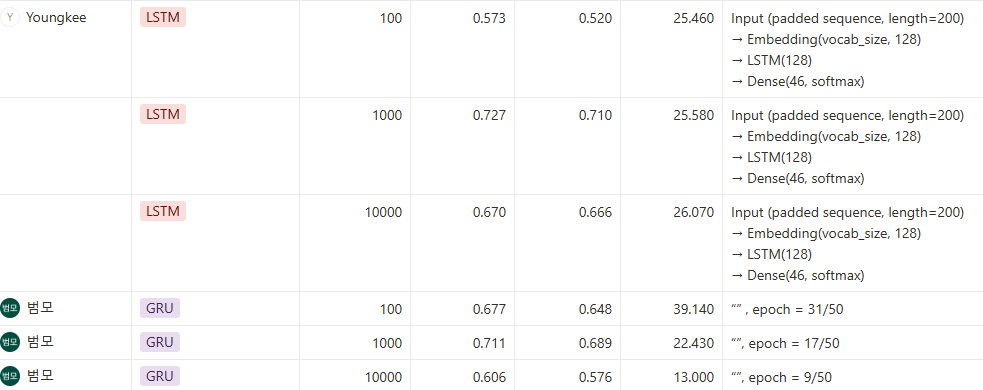

## 회고

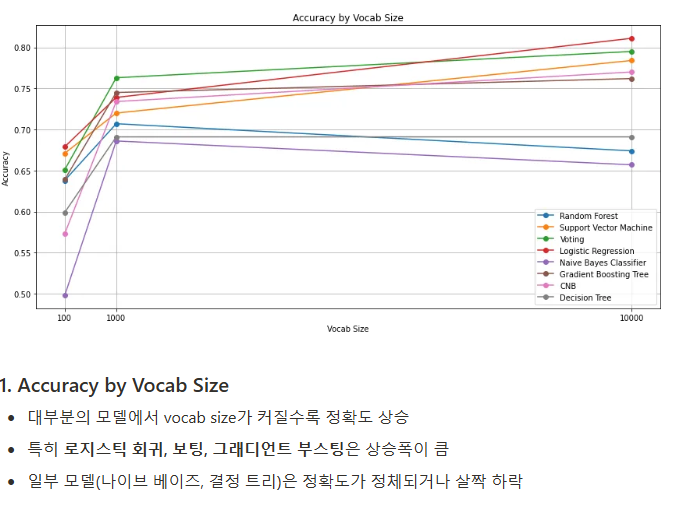

---

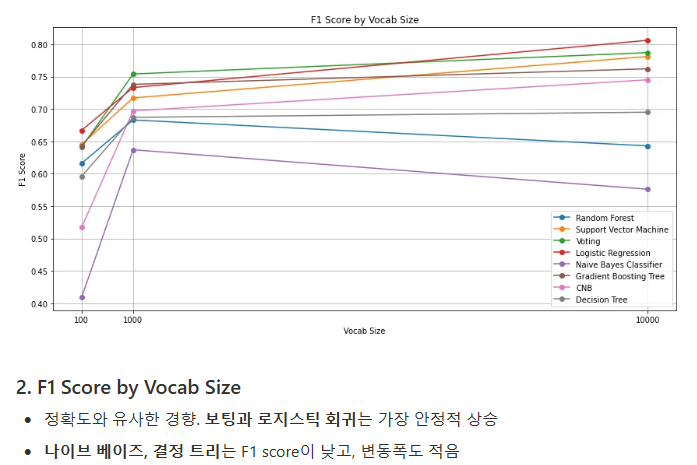

---

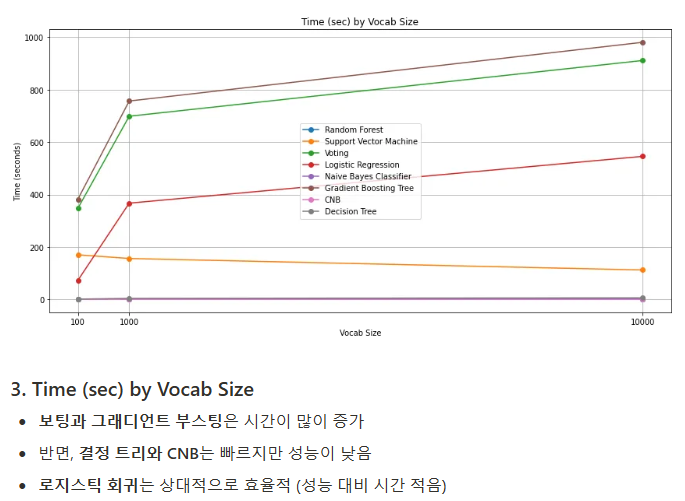

---

1. 머신러닝 8종류에서는 로지스틱 회귀와 보팅이 성능이 제일 좋았다.
2. 머신러닝은 vocab_size를 높일수록 성능이 좋아지는 경향이 있다.
3. LSTM과 GRU는 vocab_size가 1000일 때 성능이 제일 좋았다. ( vocab_size가 너무 적거나 너무 많은 경우 성능이 안 좋고 적절한 사이즈가 중요한 것 같다 )